# Bike Sharing in Washington D.C. in Dask

Ashley O'Mahony | [ashleyomahony.com](http://ashleyomahony.com) | May 2019  

***

## Introduction

### Objectives

This case study of the Washington D.C Bike Sharing System aims to predict the total number of users on an hourly basis. The dataset is [available on Kaggle](https://www.kaggle.com/marklvl/bike-sharing-dataset/home). It contains usage information of years 2011 and 2012.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington-DC-in-Dask).

### Libraries

This project uses a set of libraries for data manipulation, ploting and modelling.

In [1]:
# Loading Libraries
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.special import boxcox1p
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from dask_ml.linear_model import LinearRegression
import dask.array.stats
from dask_ml.preprocessing import DummyEncoder
from dask_ml.preprocessing import MinMaxScaler
from dask.distributed import Client
import dask.dataframe as dd
import kaggle
import datetime
import pandas as pd
from sklearn.externals.joblib import parallel_backend
import dask_xgboost
import xgboost
from dask_ml.xgboost import XGBRegressor
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', 500)
kaggle.api.authenticate()
sns.set(style='white')

In [2]:
from dask.distributed import Client, progress
client = Client()
client

Client Scheduler: tcp://127.0.0.1:63586 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


### Data Loading

The dataset is downloaded from Kaggle and consisting in two CSV file: `day.csv` and `hour.csv`. The files are loaded directly from the repository.

In [3]:
!kaggle datasets download - d marklvl/bike-sharing-dataset - p ./assets/data
!unzip - o ./assets/data/*.zip - d ./assets/data
!unzip - o ./assets/data/*.zip - d ./assets/data

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: d marklvl/bike-sharing-dataset - p ./assets/data
unzip:  cannot find or open o, o.zip or o.ZIP.
unzip:  cannot find or open o, o.zip or o.ZIP.


In [4]:
hours_df = dd.from_pandas(pd.read_csv("./assets/data/hour.csv", parse_dates=['dteday']),
                          npartitions=1)
hours_df.head()

/anaconda3/lib/python3.7/site-packages/distributed/worker.py:2791: UserWarning: Large object of size 2.36 MB detected in task graph: 
  (       instant     dteday  season  yr  mnth  hr   ... 17 columns], 5)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
days_df = dd.from_pandas(pd.read_csv("./assets/data/day.csv", parse_dates=['dteday']),
                         npartitions=1)
days_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [6]:
# Shape of the data frame
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('hour.csv:',
                                             hours_df.shape[0].compute(), 'rows |', hours_df.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('day.csv:',
                                             days_df.shape[0].compute(), 'rows |', days_df.shape[1], 'columns'))

hour.csv:  17379 rows |  17 columns
day.csv:     731 rows |  16 columns


In [7]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                         'Date': df.dtypes == 'datetime64[ns]',
                         })
    return desc

In [8]:
df_desc(days_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,datetime64[ns],0,False,False,False,True
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False
temp,float64,0,True,False,False,False


In [9]:
df_desc(hours_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,datetime64[ns],0,False,False,False,True
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
hr,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False


The dataset `day.csv` consists in 731 rows and 16 columns. The dataset `hour.csv` consists in 17,379 rows and 17 columns. Both datasets have the same columns, with an additional column for hours in `hour.csv`.

Each row provides information for each day or each hour. None of the attributes contains any NA. Four (4) of these attributes contain decimal numbers, nine (9) contain integers, three (3) contain booleans, and one (1) contains date values stored as string.

For better readability, the columns of both data frames are renamed and data types are adjusted.

In [10]:
# HOURS DATASET
# Renaming columns names to more readable names
hours_df = hours_df.rename(columns={'instant': 'id',
                                    'dteday': 'date',
                                    'weathersit': 'weather_condition',
                                    'hum': 'humidity',
                                    'mnth': 'month',
                                    'cnt': 'total_bikes',
                                    'hr': 'hour',
                                    'yr': 'year',
                                    'temp': 'actual_temp',
                                    'atemp': 'feeling_temp'})

# Categorical variables
hours_df = hours_df.categorize(columns=['season', 'holiday', 'weekday',
                                        'workingday', 'weather_condition',
                                        'month', 'year', 'hour'])

# DAYS DATASET
# Renaming columns names to more readable names
days_df = days_df.rename(columns={'instant': 'id',
                                  'dteday': 'date',
                                  'weathersit': 'weather_condition',
                                  'hum': 'humidity',
                                  'mnth': 'month',
                                  'cnt': 'total_bikes',
                                  'yr': 'year',
                                  'temp': 'actual_temp',
                                  'atemp': 'feeling_temp'})

# Categorical variables
days_df = days_df.categorize(columns=['season', 'holiday', 'weekday',
                                      'workingday', 'weather_condition',
                                      'month', 'year'])

In [11]:
hours_df.head()

,id,date,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [12]:
hours_df.compute().describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [13]:
df_desc(days_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False


In [14]:
df_desc(hours_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [15]:
# Lists values of categorical variables
categories = {'season': hours_df['season'].compute().unique().tolist(),
              'year': hours_df['year'].compute().unique().tolist(),
              'month': hours_df['month'].compute().unique().tolist(),
              'hour': hours_df['hour'].compute().unique().tolist(),
              'holiday': hours_df['holiday'].compute().unique().tolist(),
              'weekday': hours_df['weekday'].compute().unique().tolist(),
              'workingday': hours_df['workingday'].compute().unique().tolist(),
              'weather_condition': hours_df['weather_condition'].compute().unique().tolist(),
              }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1]:
        print()

holiday:
[0, 1]

hour:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[1, 2, 3, 4]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [16]:
df_desc(hours_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [17]:
days_df.head()

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [18]:
days_df.compute().describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [19]:
# Lists values of categorical variables
categories = {'season': days_df['season'].compute().unique().tolist(),
              'year': days_df['year'].compute().unique().tolist(),
              'month': days_df['month'].compute().unique().tolist(),
              'holiday': days_df['holiday'].compute().unique().tolist(),
              'weekday': days_df['weekday'].compute().unique().tolist(),
              'workingday': days_df['workingday'].compute().unique().tolist(),
              'weather_condition': days_df['weather_condition'].compute().unique().tolist(),
              }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1]:
        print()

holiday:
[0, 1]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[2, 1, 3]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [20]:
df_desc(days_df.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False


For this study, we will only work with the dataset `hours`. The datasets contain 17 variables with no NAs:

- `id`: numerical, integer values.  
  *Record index. __This variable won't be considered in the study.__*
  
  
- `date`: numerical, date values.  
  *Date.*


- `season`: encoded categorical, integer between 1 and 4.  
  *Season: 2=Spring, 3=Summer, 4=Fall, 1=Winter.*  
  *__Note: the seasons mentioned on the Kaggle page didn't correspond to the real seasons. We readjusted the parameters accordingly.__*


- `year`: encoded categorical, integer between 0 and 1.  
  *Year: 0=2011, 1=2012.*
  
  
- `month`: encoded categorical, integer between 1 and 12.  
  *Month.*
  
  
- `hour`: encoded categorical, integer between 1 and 23.  
  *Hour.*
  
  
- `holiday`: encoded categorical, boolean.  
  *Flag indicating if the day is a holiday.*


- `weekday`: encoded categorical, integer between 0 and 6.  
  *Day of the week (0=Sunday, ... 6=Saturday).*


- `workingday`: encoded categorical, boolean.  
  *Flag indicating if the day is a working day.*
  
  
- `weather_condition`: encoded categorical, integer between 1 and 4.  
  *Weather condition (1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain).*


- `actual_temp`: numerical, decimal values between 0 and 1.  
  *Normalized temperature in Celsius (min = -16, max = +50).*


- `feeling_temp`: numerical, decimal values between 0 and 1.  
  *Normalized feeling temperature in Celsius (min = -8, max = +39).*


- `humidity`: numerical, decimal values between 0 and 1.  
  *Normalized humidity.*


- `windspeed`: numerical, decimal values between 0 and 1.  
  *Normalized wind speed.*


- `casual`: numerical, integer.  
  *Count of casual users. This variable won't be considered in the study.*


- `registered`: numerical, integer.  
  *Count of registered users. This variable won't be considered in the study.*


- `total_bikes`: numerical, integer.  
  *Count of total rental bikes (casual+registered). This is the __target variable__ of the study, the one to be modelled.*

In [21]:
# Remove variable id
hours_df = hours_df.drop('id', axis=1)

### Exploratory Data Analysis

#### Bike sharing utilization over the two years

The objective of this study is to build a model to predict the value of the variable `total_bikes`, based on the other variables available.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


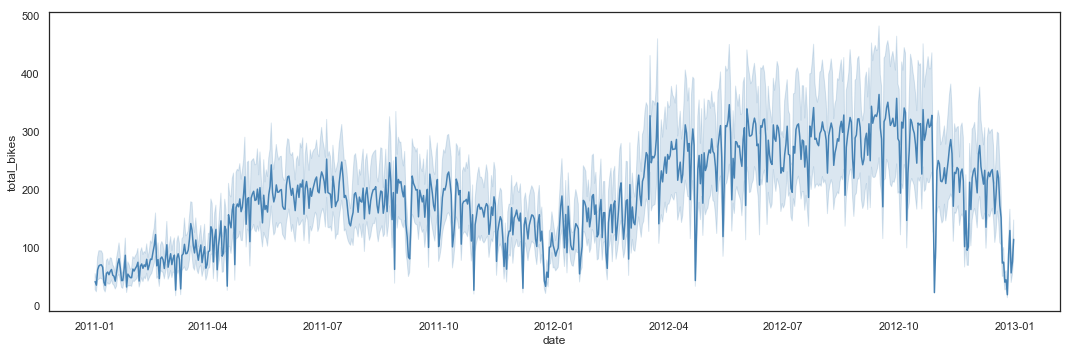

In [22]:
# Total_bikes evolution per day
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().date,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.tight_layout()

Based on the two years dataset, it seems that the utilization of the bike sharing service has increased over the period. The number of bikes rented per day also seems to vary depending on the season, with Spring and Summer months being showing a higher utilization of the service.

#### Bike sharing utilization by Month

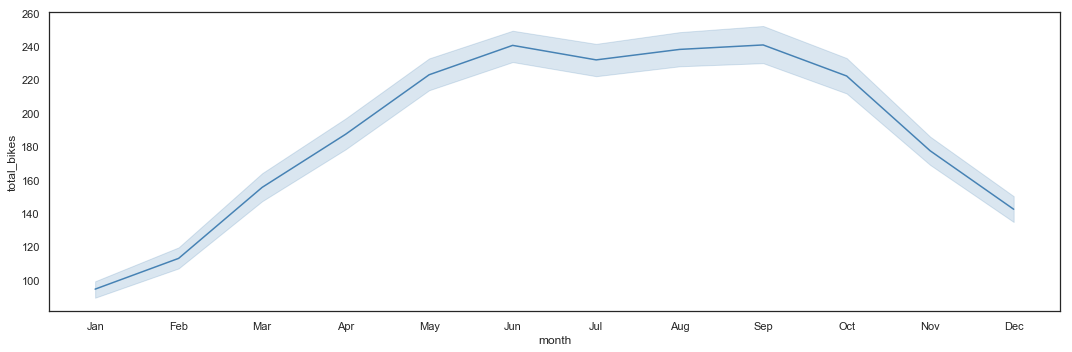

In [23]:
# Total_bikes by Month - Line Plot
plt.figure(figsize=(15, 5))
g = sns.lineplot(x=hours_df.compute().month,
                 y=hours_df.compute().total_bikes,
                 color='steelblue') \
    .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.tight_layout()

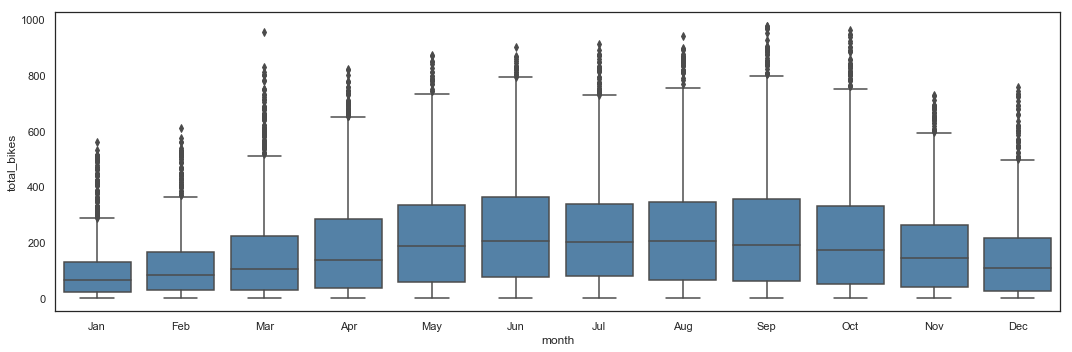

In [24]:
# Total_bikes by Month - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().month,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

The average utilization per month seems to increase between April and October, with a higher variance too.

#### Bike sharing utilization by Hour

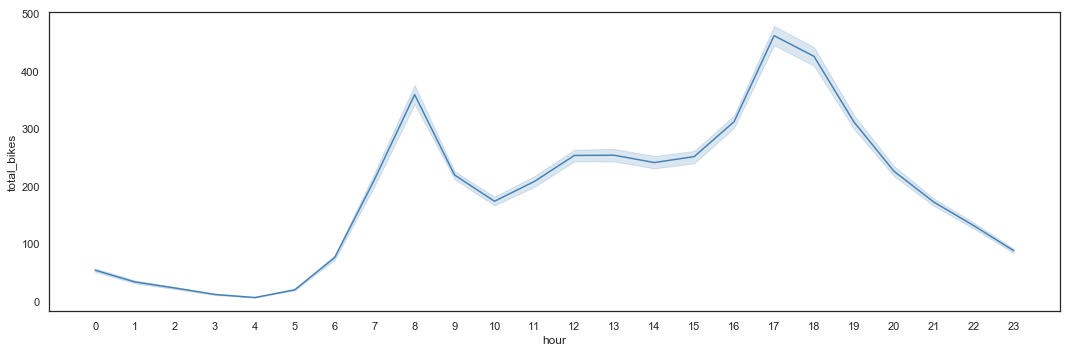

In [25]:
# Total_bikes by Hour - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().hour,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
plt.tight_layout()

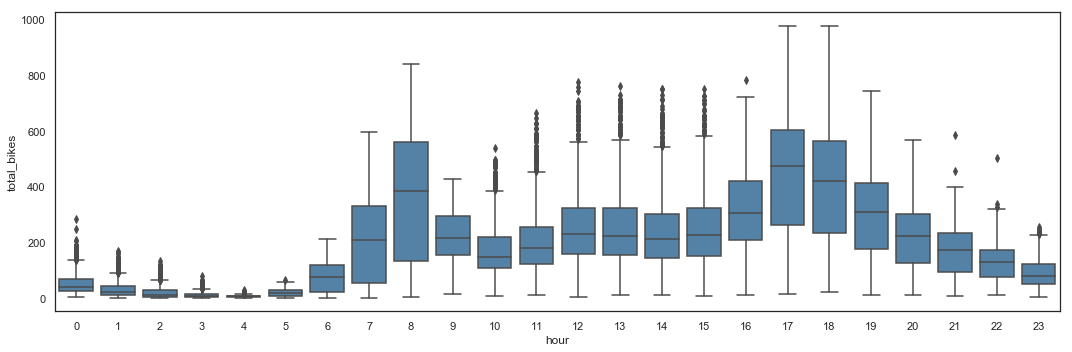

In [26]:
# Total_bikes by Hour - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().hour,
            y=hours_df.compute().total_bikes,
            color='steelblue')
plt.tight_layout()

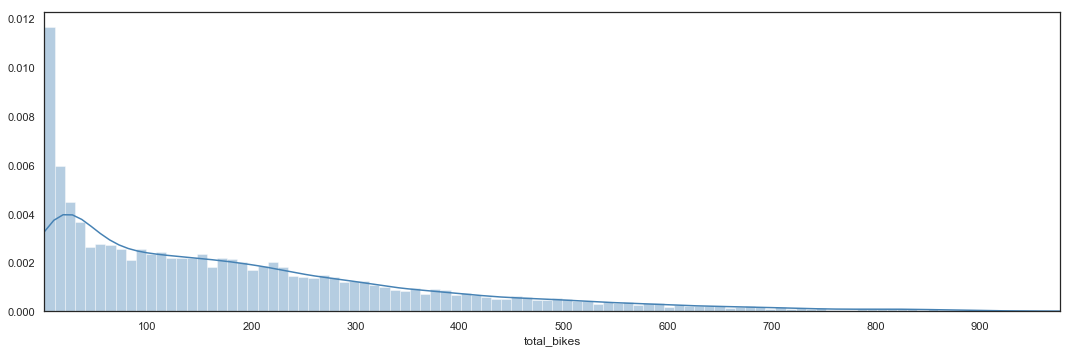

In [27]:
# Total_bikes by Hour - Distribution
plt.figure(figsize=(15, 5))
sns.distplot(hours_df.compute().total_bikes,
             bins=100,
             color='steelblue').axes.set(xlim=(min(hours_df.compute().total_bikes), max(hours_df.compute().total_bikes)),
                                         xticks=[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.tight_layout()

The utilization seems really similar over the day, with 2 peaks around 8am and between 5pm and 6pm. The box plot shows potential outliers in the data, which will be removed after the Feature Construction stage. It also highlight an important variance during day time, especially at peak times. The distribution plot shows that utilization is most of the time below 40 bikes simultaneously, and can reach about 1,000 bikes.

#### Bike sharing utilization by Season

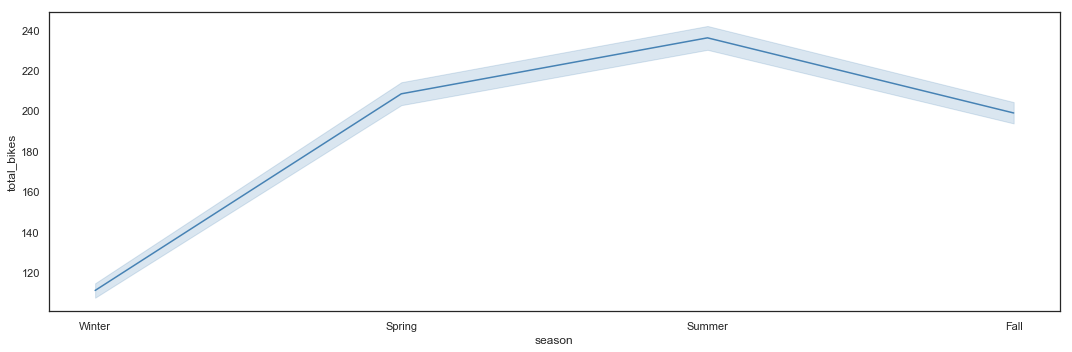

In [28]:
# Total_bikes by Season - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().season,
             y=hours_df.compute().total_bikes,
             color='steelblue') \
    .axes.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
plt.xticks([1, 2, 3, 4])
plt.tight_layout()

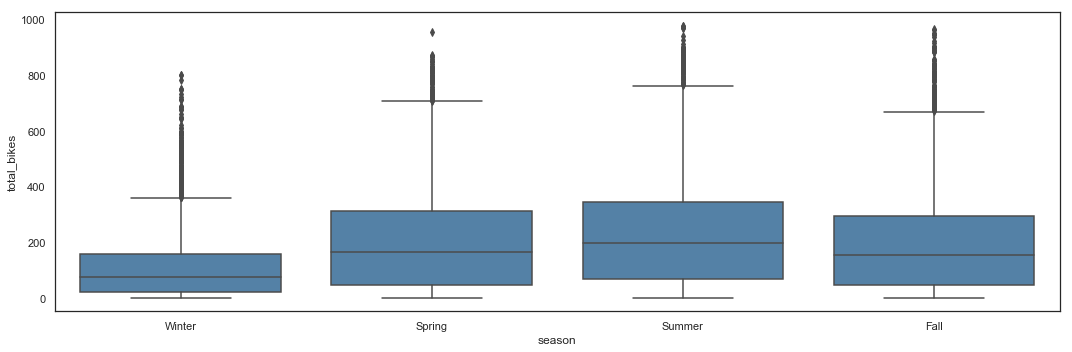

In [29]:
# Total_bikes by Season - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().season,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
plt.tight_layout()

Summer appears to be the high season, with Spring and Fall having similar utilization shapes. Winter logically appears to be the low season with, however, potential utilization peaks which can reach the same number of bikes than in high season.

#### Bike sharing utilization by Holiday

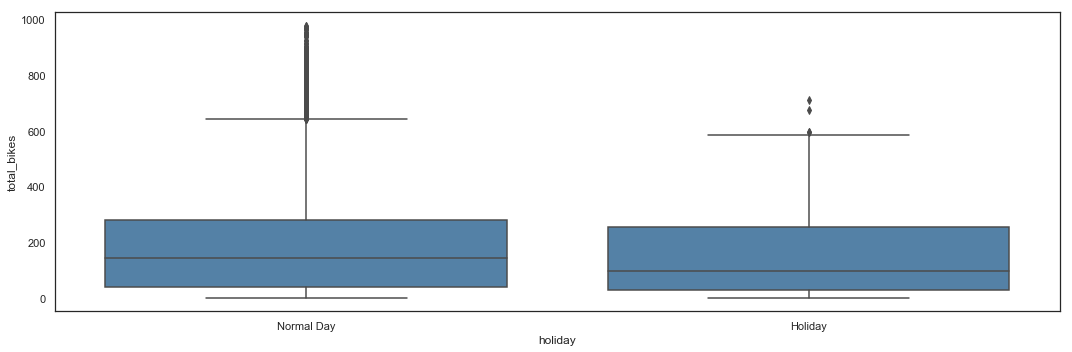

In [30]:
# Total_bikes by Holidays - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().holiday,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Normal Day', 'Holiday'])
plt.tight_layout()

Utilization of bikes during holidays seems lower and with less peaks.

#### Bike sharing utilization by Weekday

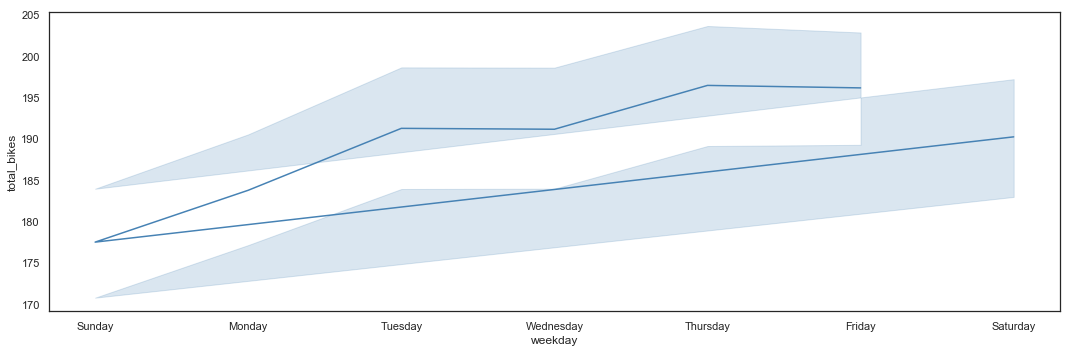

In [31]:
# Total_bikes by Weekday - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().weekday,
             y=hours_df.compute().total_bikes,
             color='steelblue') \
    .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.xticks([0, 1, 2, 3, 4, 5, 6])
plt.tight_layout()

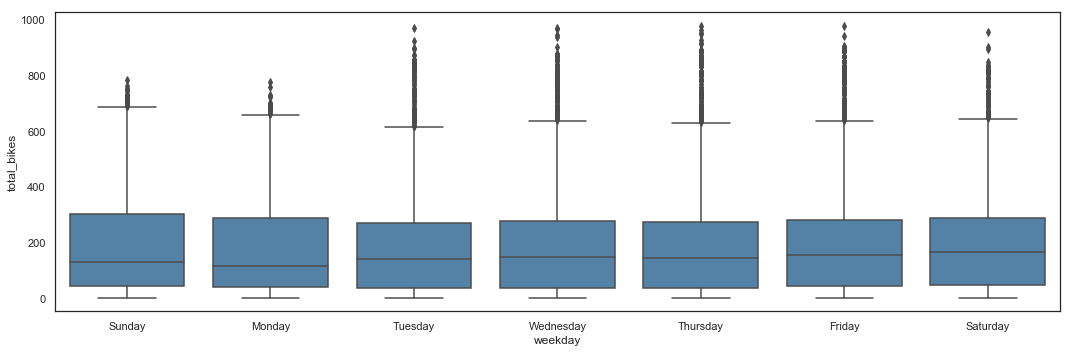

In [32]:
# Total_bikes by Weekday - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().weekday,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.tight_layout()

The average utilization per hour seems higher at the end of the week, but overall, weekends appear to have lower frequentation and weekdays have higher peaks.

#### Bike sharing utilization by Working Day

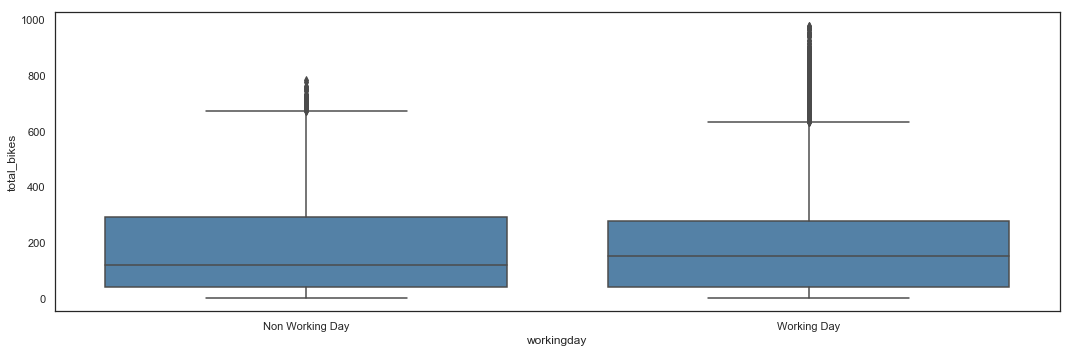

In [33]:
# Total_bikes by Working Day - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().workingday,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Non Working Day', 'Working Day'])
plt.tight_layout()

Utilization seems higher during working days, with higher peaks.

#### Bike sharing utilization by Weather Condition

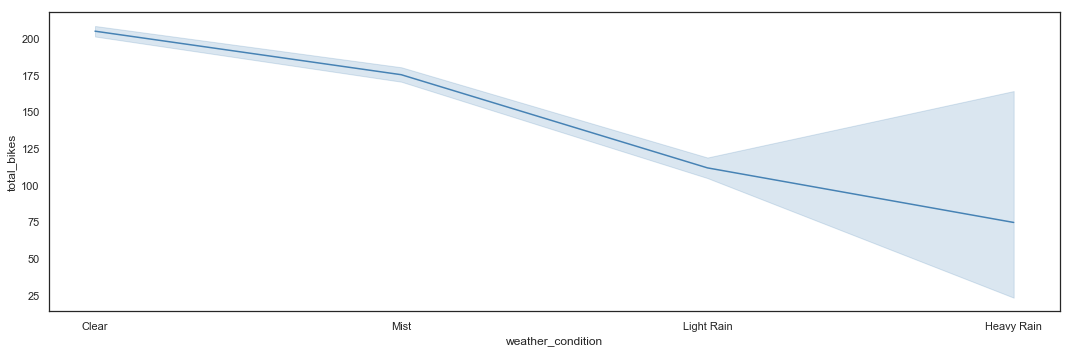

In [34]:
# Total_bikes by Weather Condition - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().weather_condition,
             y=hours_df.compute().total_bikes,
             color='steelblue') \
    .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.xticks([1, 2, 3, 4])
plt.tight_layout()

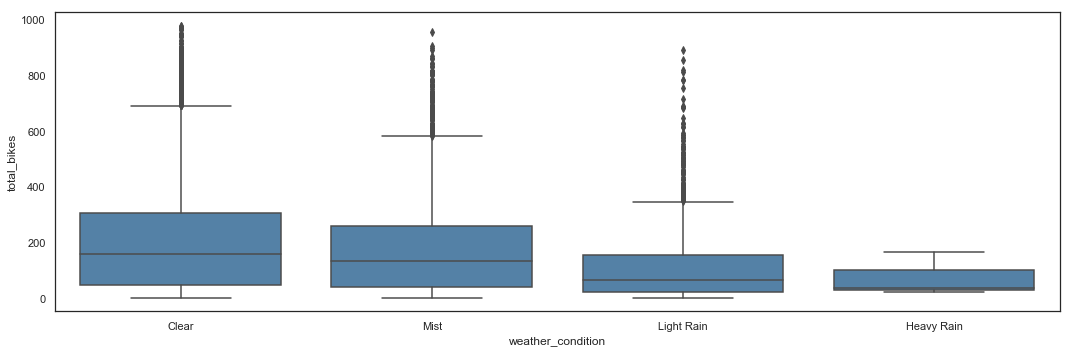

In [35]:
# Total_bikes by Weather Condition - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().weather_condition,
            y=hours_df.compute().total_bikes,
            color='steelblue') \
    .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.tight_layout()

Unsurprisingly, bike sharing utilization is getting worse with bad weather.

#### Bike sharing utilization by Actual Temperature

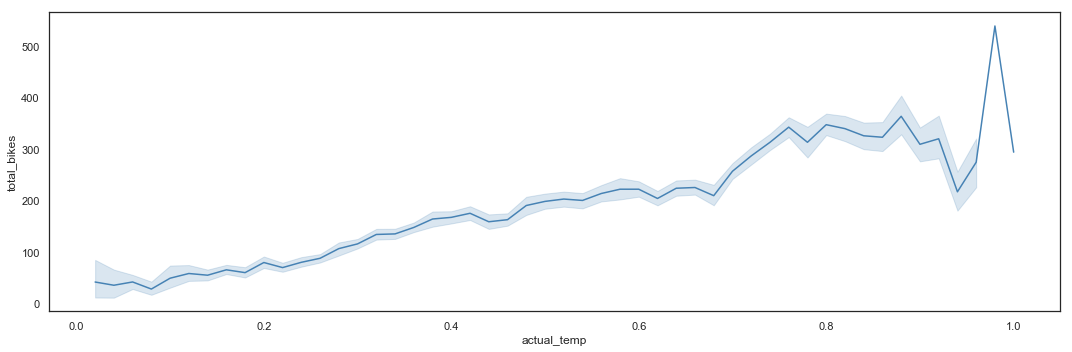

In [36]:
# Total_bikes by Actual Temperature - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().actual_temp,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.tight_layout()

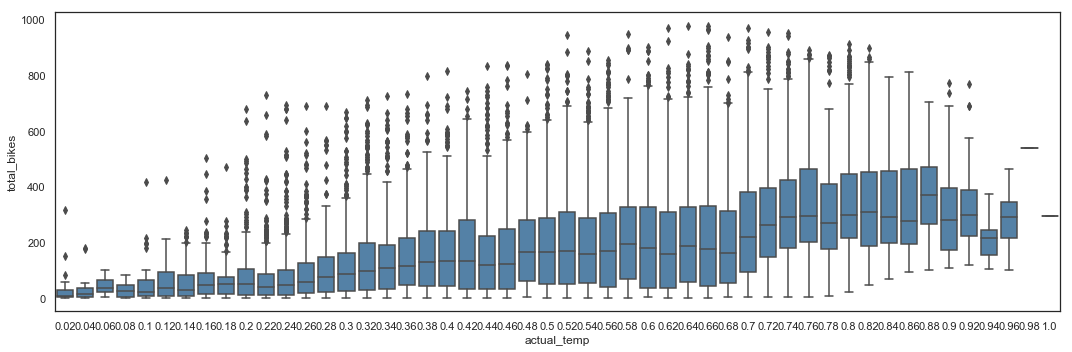

In [37]:
# Total_bikes by Actual Temperature - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().actual_temp,
            y=hours_df.compute().total_bikes,
            color='steelblue')
plt.tight_layout()

The utilization is almost inexistant for sub-zero temperatures. It then grows with the increase of temperature, but drops down when it gets extremely hot.

#### Bike sharing utilization by Feeling Temperature

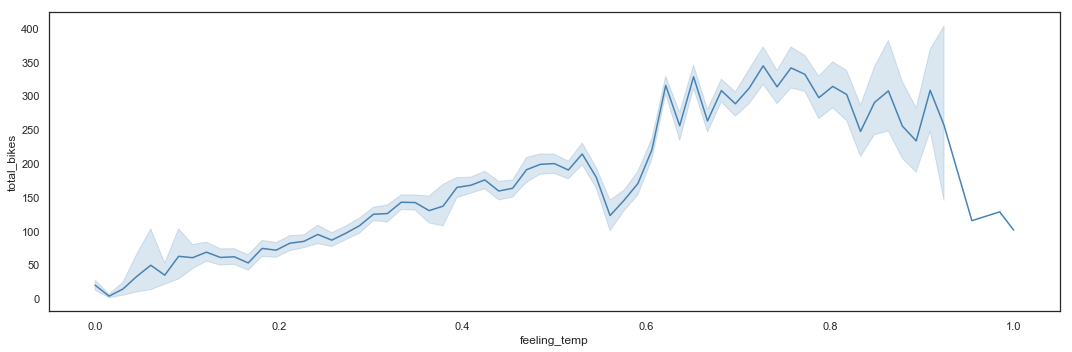

In [38]:
# Total_bikes by Feeling Temperature - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().feeling_temp,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.tight_layout()

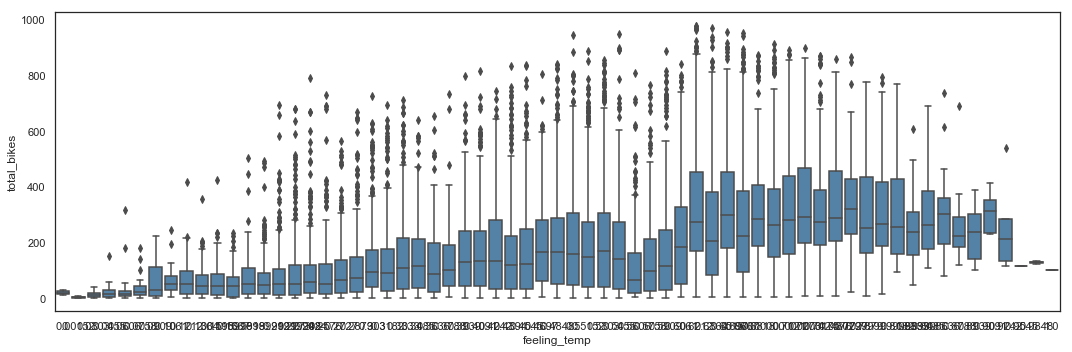

In [39]:
# Total_bikes by Feeling Temperature - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().feeling_temp,
            y=hours_df.compute().total_bikes,
            color='steelblue')
plt.tight_layout()

The utilization by feeling temperature follows the same rules than by actual temperature.

#### Bike sharing utilization by Humidity

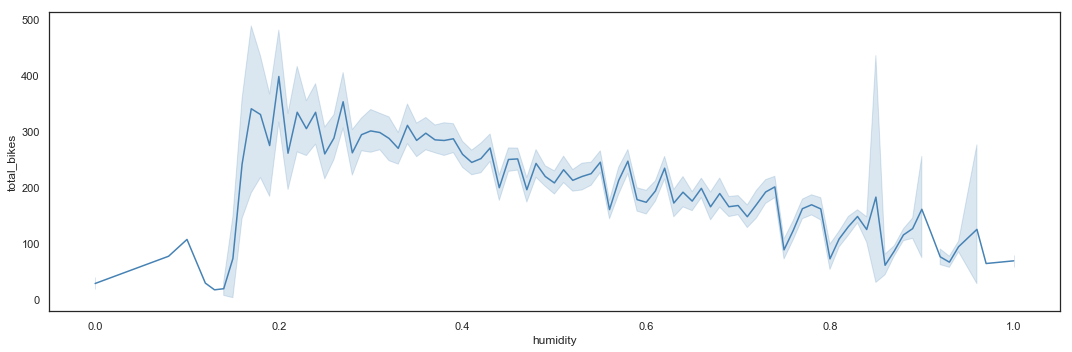

In [40]:
# Total_bikes by Humidity - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().humidity,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.tight_layout()

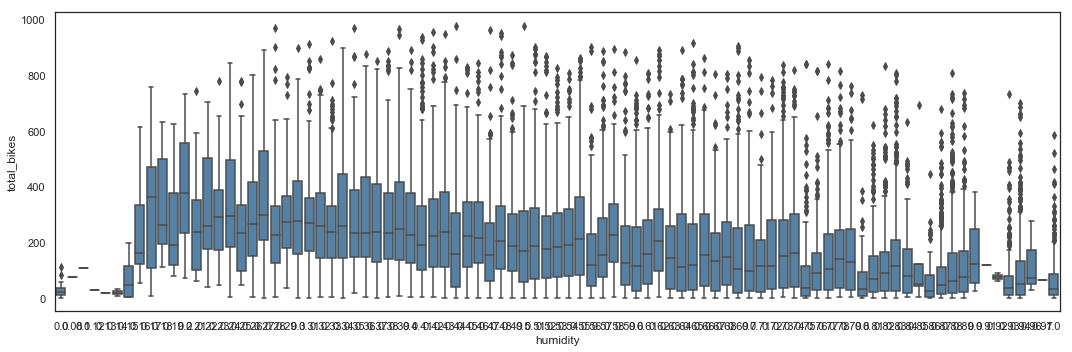

In [41]:
# Total_bikes by Humidity - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().humidity,
            y=hours_df.compute().total_bikes,
            color='steelblue')
plt.tight_layout()

The utilization of bike sharing services is decreasing with the increase of humidity.

#### Bike sharing utilization by Wind Speed

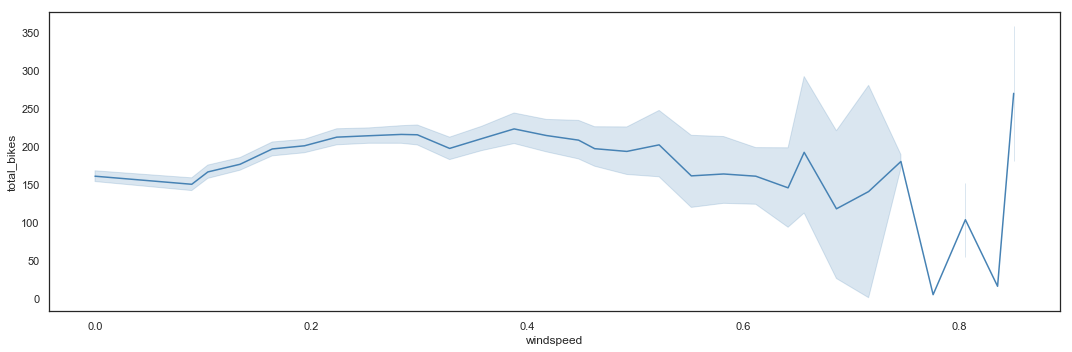

In [42]:
# Total_bikes by Wind Speed - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(x=hours_df.compute().windspeed,
             y=hours_df.compute().total_bikes,
             color='steelblue')
plt.tight_layout()

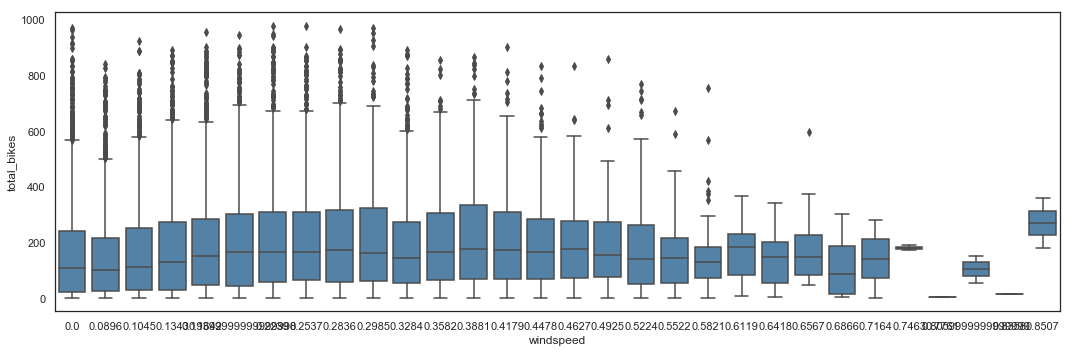

In [43]:
# Total_bikes by Wind Speed - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().windspeed,
            y=hours_df.compute().total_bikes,
            color='steelblue')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### Bike sharing utilization by Casual

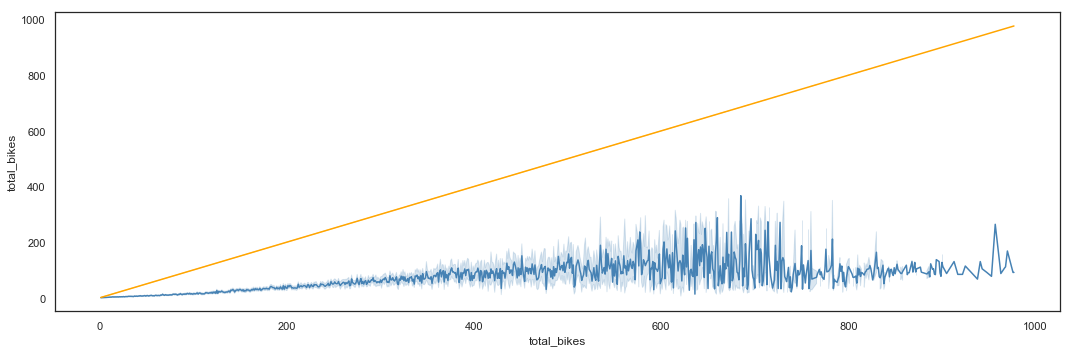

In [44]:
# Total_bikes by Casual - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(y=hours_df.compute().casual,
             x=hours_df.compute().total_bikes,
             color='steelblue')
sns.lineplot(y=hours_df.compute().total_bikes,
             x=hours_df.compute().total_bikes,
             color='orange')
plt.tight_layout()

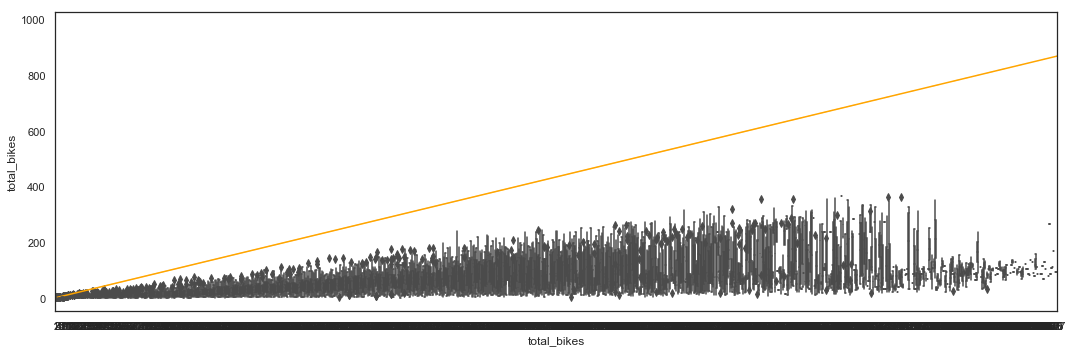

In [45]:
# Total_bikes by Casual - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(y=hours_df.compute().casual,
            x=hours_df.compute().total_bikes,
            color='steelblue')
sns.lineplot(y=hours_df.compute().total_bikes,
             x=hours_df.compute().total_bikes,
             color='orange')
plt.tight_layout()

The number of casual users seems to be quite low compared to the total users, but there are peaks of activity when total utilization reaches values between 500 and 800 bikes.

#### Bike sharing utilization by Registered

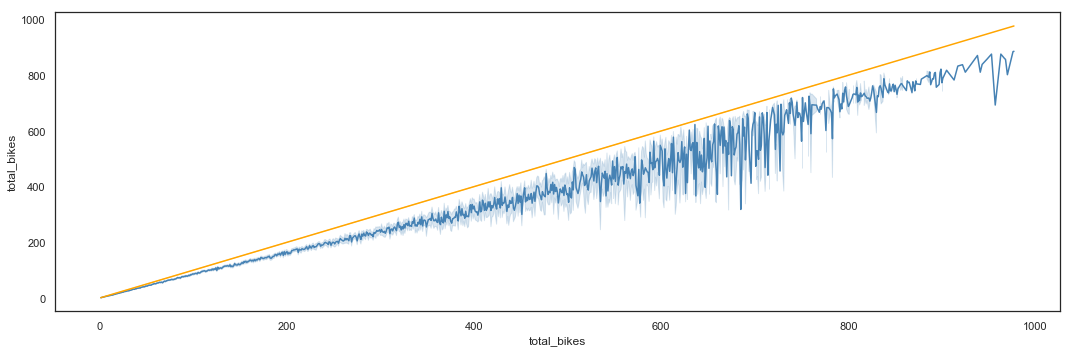

In [46]:
# Total_bikes by Registered - Line Plot
plt.figure(figsize=(15, 5))
sns.lineplot(y=hours_df.compute().registered,
             x=hours_df.compute().total_bikes,
             color='steelblue')
sns.lineplot(y=hours_df.compute().total_bikes,
             x=hours_df.compute().total_bikes,
             color='orange')
plt.tight_layout()

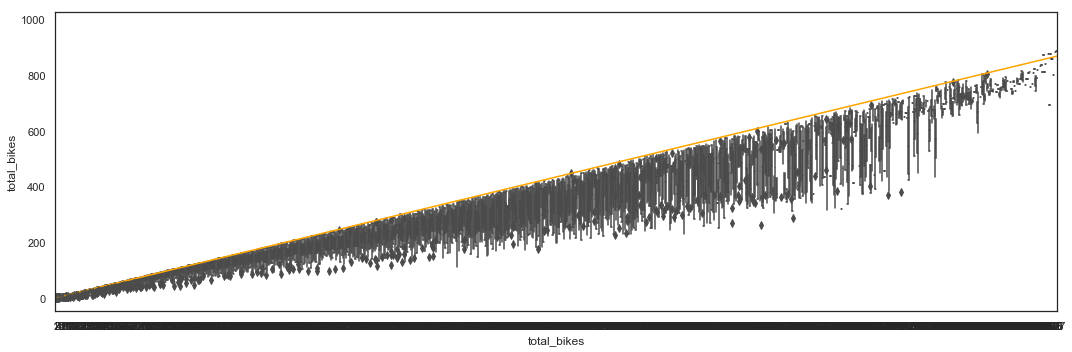

In [47]:
# Total_bikes by Registered - Box Plot
plt.figure(figsize=(15, 5))
sns.boxplot(y=hours_df.compute().registered,
            x=hours_df.compute().total_bikes,
            color='steelblue')
sns.lineplot(y=hours_df.compute().total_bikes,
             x=hours_df.compute().total_bikes,
             color='orange')
plt.tight_layout()

The number of registered users is usually high, compared to the total number of bikes. There are however drops between 500 and 800 total users.

#### Total_Bikes by Hour with Holiday Hue

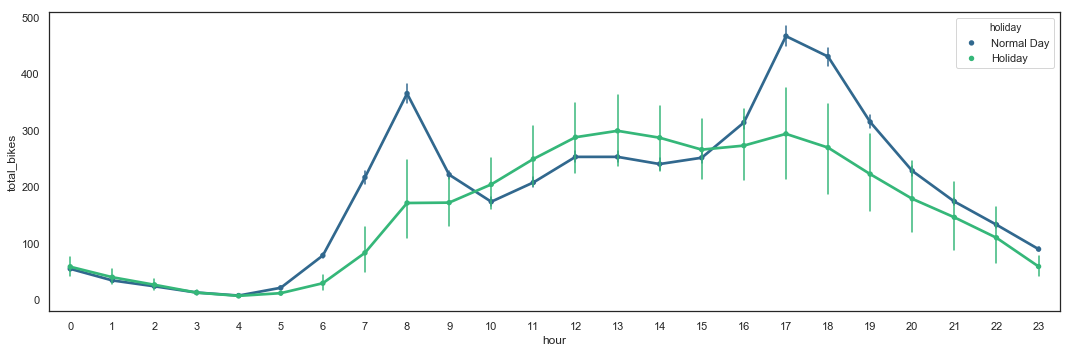

In [48]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().total_bikes,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().holiday.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Normal Day', 'Holiday']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

The utilization by hour during normal days differs from the utilization during holidays. During normal days, two (2) peaks are present during commute times (around 8am and 5-6pm), while during holidays, utilization is higher during the day between 10am and 8pm. Utilization during holidays also shows a higher variance.

#### Total_Bikes by Hour with Working Day Hue

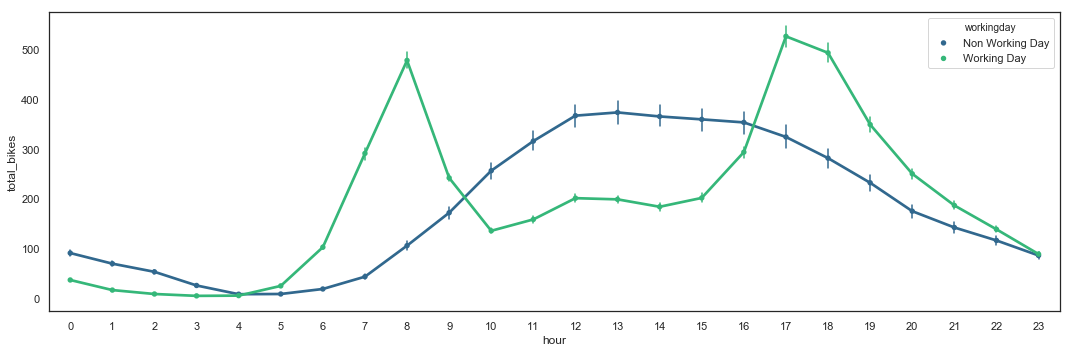

In [49]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().total_bikes,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().workingday.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Non Working Day', 'Working Day']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
# plt.axhline(hours_df.total_bikes.mean()+0.315*hours_df.total_bikes.mean(), color='orange')
plt.tight_layout()

Quite similar than the utilization by holiday, the utilization by hour during working days differs from the utilization during non working days. During working days, two (2) peaks are present during commute times (around 8am and 5-6pm), while during non working days, utilization is higher during the day between 10am and 8pm. Interestingly, utilization during non working day seems to have less variance than during holidays.

#### Total_Bikes by Hour with Weekday Hue

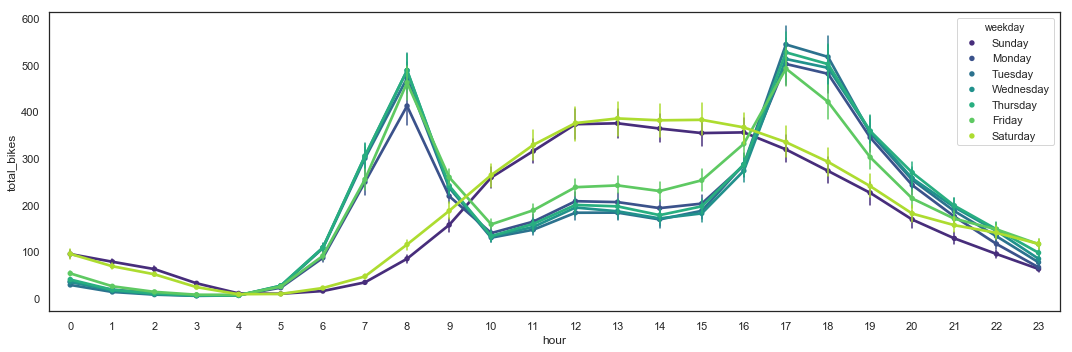

In [50]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().total_bikes,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().weekday.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Sunday', 'Monday', 'Tuesday',
            'Wednesday', 'Thursday', 'Friday', 'Saturday']
# plt.axhline(hours_df.total_bikes.mean(), color='steelblue')
# plt.axhline(hours_df.total_bikes.mean()+0.315*hours_df.total_bikes.mean(), color='orange')
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

The utilization by hour during weekdays differs from the utilization during weekends. During weekdays, two (2) peaks are present during commute times (around 8am and 5-6pm), while during weekends, utilization is higher during the day between 10am and 6pm.

#### Total_Bikes by Hour with Weekday Hue for Registered Users

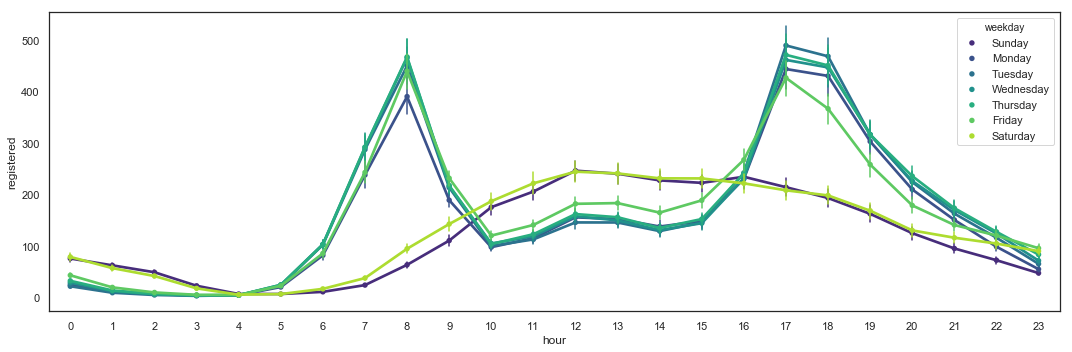

In [51]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().registered,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().weekday.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Sunday', 'Monday', 'Tuesday',
            'Wednesday', 'Thursday', 'Friday', 'Saturday']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

Registered users seem to be responsible for the two (2) peaks during commute times. They still use the bikes during the weekends.

#### Total_Bikes by Hour with Weekday Hue for Casual Users

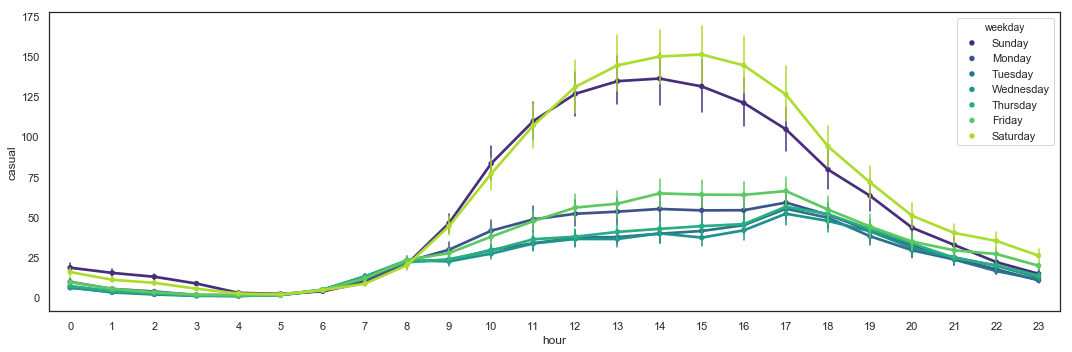

In [52]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().casual,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().weekday.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Sunday', 'Monday', 'Tuesday',
            'Wednesday', 'Thursday', 'Friday', 'Saturday']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

Casual users are mainly using the bikes during the weekends.

#### Total_Bikes by Hour with Weather Conditions Hue

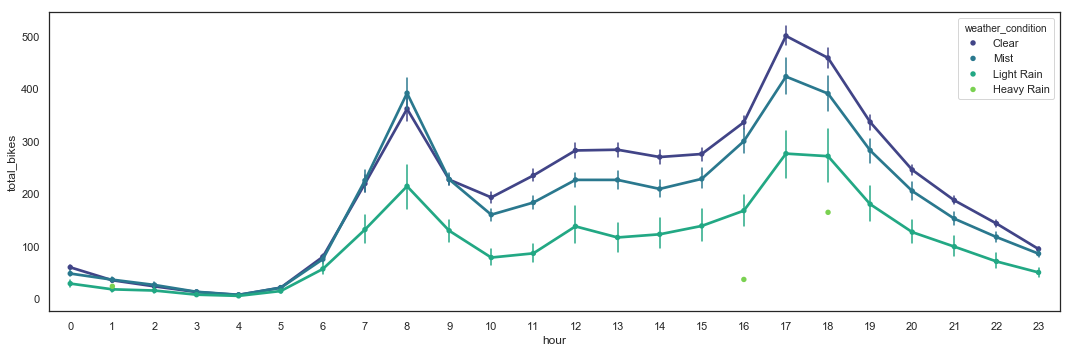

In [53]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().total_bikes,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().weather_condition.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Clear', 'Mist', 'Light Rain', 'Heavy Rain']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

The weather seems to have a consistent impact on the utilization by hour, except for mist which doesn't seem to discourage morning commuters.

#### Total_Bikes by Hour with Seasons Hue

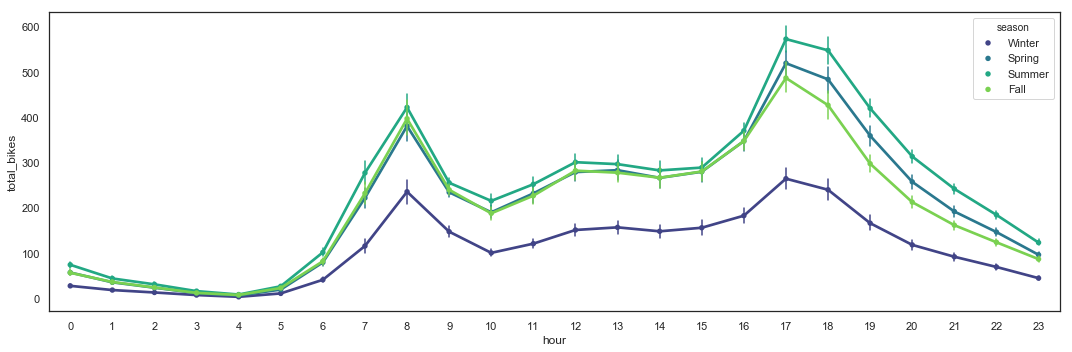

In [54]:
plt.figure(figsize=(15, 5))
g = sns.pointplot(y=hours_df.compute().total_bikes,
                  x=hours_df.compute().hour,
                  hue=hours_df.compute().season.astype('int'),
                  palette='viridis',
                  markers='.',
                  errwidth=1.5)
g_legend = g.axes.get_legend()
g_labels = ['Winter', 'Spring', 'Summer', 'Fall']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)
plt.tight_layout()

The season seems to have a consistent impact on the utilization by hour, with Winter discouraging a big part of the users.

#### Humidity by Actual Temperature

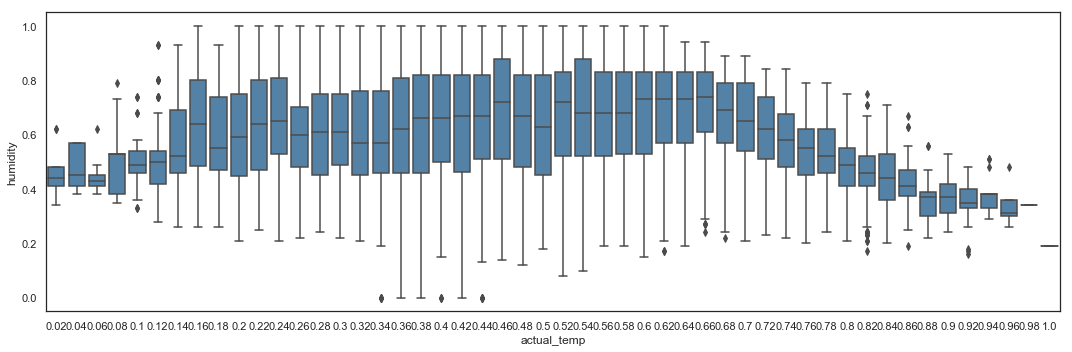

In [55]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=hours_df.compute().actual_temp,
            y=hours_df.compute().humidity,
            color='steelblue')
plt.tight_layout()

The humidity seems to be changing regardless of the actual temperature, except for extreme temperature values where humidity seems to stabilize.

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

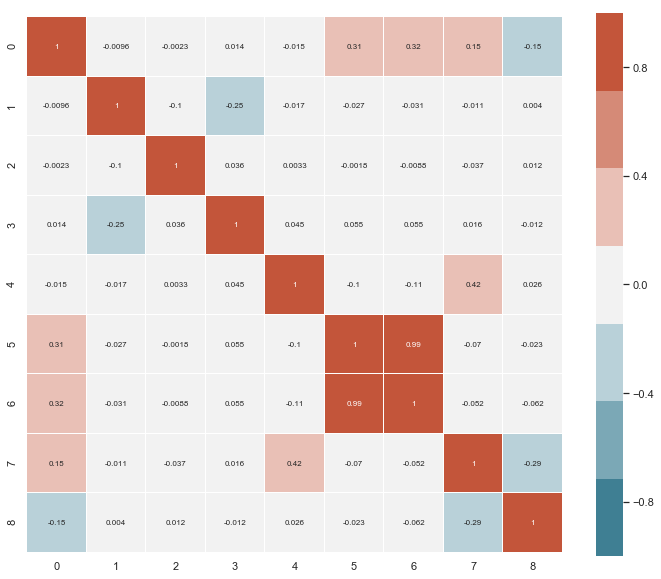

In [56]:
hours_df_corr = hours_df.copy()
hours_df_corr = hours_df_corr.drop(
    ['date', 'year', 'month', 'hour', 'casual', 'registered', 'total_bikes'], axis=1)
for column in hours_df_corr.columns:
    hours_df_corr[column] = hours_df_corr[column].astype('float')

plt.figure(figsize=(12, 10))
sns.heatmap(hours_df_corr.corr(),
            cmap=sns.diverging_palette(220, 20, n=7), vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

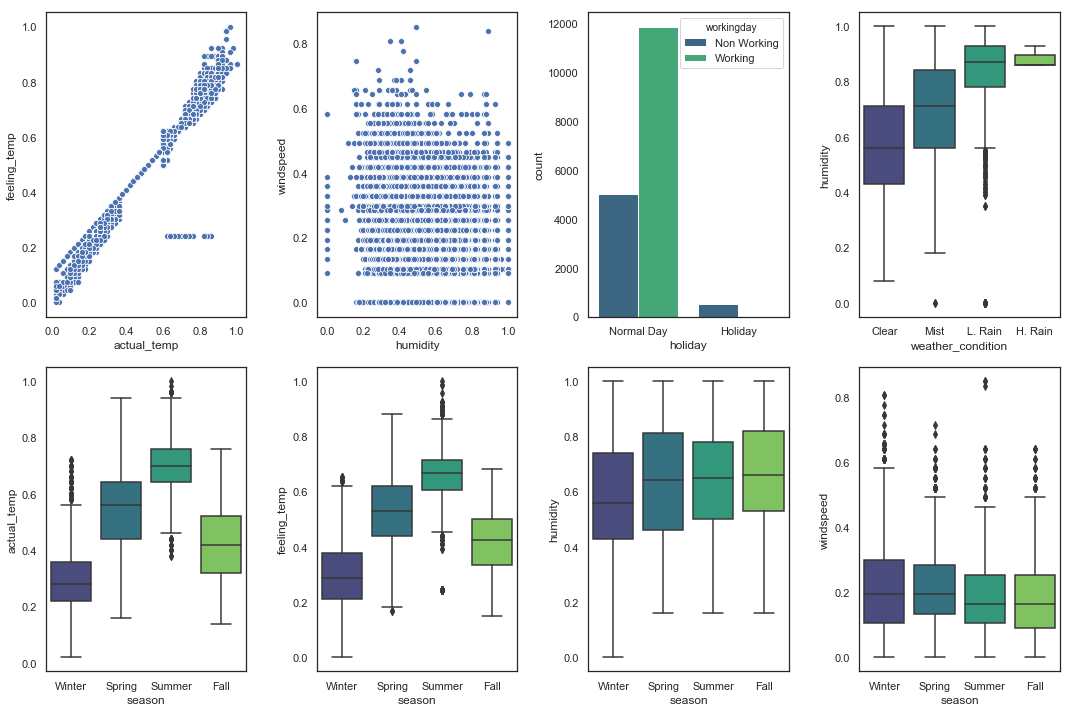

In [57]:
fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 4)

sns.scatterplot(hours_df['actual_temp'].compute(
), hours_df['feeling_temp'].compute(), palette=('viridis'), ax=axs[0, 0])

sns.scatterplot(hours_df['humidity'].compute(
), hours_df['windspeed'].compute(), palette=('viridis'), ax=axs[0, 1])

sns.countplot(hours_df['holiday'].compute(
), hue=hours_df['workingday'].compute(), palette=('viridis'), ax=axs[0, 2])
axs[0, 2].set_xticklabels(labels=['Normal Day', 'Holiday'])
g_legend = axs[0, 2].get_legend()
g_labels = ['Non Working', 'Working']
for t, l in zip(g_legend.texts, g_labels):
    t.set_text(l)

sns.boxplot(hours_df['weather_condition'].compute(
), hours_df['humidity'].compute(), palette=('viridis'), ax=axs[0, 3])
axs[0, 3].set_xticklabels(labels=['Clear', 'Mist', 'L. Rain', 'H. Rain'])

sns.boxplot(hours_df['season'].compute(
), hours_df['actual_temp'].compute(), palette=('viridis'), ax=axs[1, 0])
axs[1, 0].set_xticklabels(labels=['Winter', 'Spring', 'Summer', 'Fall'])

sns.boxplot(hours_df['season'].compute(
), hours_df['feeling_temp'].compute(), palette=('viridis'), ax=axs[1, 1])
axs[1, 1].set_xticklabels(labels=['Winter', 'Spring', 'Summer', 'Fall'])

sns.boxplot(hours_df['season'].compute(
), hours_df['humidity'].compute(), palette=('viridis'), ax=axs[1, 2])
axs[1, 2].set_xticklabels(labels=['Winter', 'Spring', 'Summer', 'Fall'])

sns.boxplot(hours_df['season'].compute(
), hours_df['windspeed'].compute(), palette=('viridis'), ax=axs[1, 3])
axs[1, 3].set_xticklabels(labels=['Winter', 'Spring', 'Summer', 'Fall'])

fig.tight_layout()

The correlation matrix shows a high correlation between `actual_temp` and `feeling_temp`. Thus, only the `actual_temp` variable will be used in the study, and the `feeling_temp` will be removed from the dataset.

Another interesting relationship exists between `holiday` and `workingday`. Every holiday is a non-working day. Based on previous plots, the utilization of bikes per hour based on `workingday` seems to be more stable than based on `holiday`, thus the variable `holiday` will be removed.

Some other logical correlations can be found between meteorological conditions and seasons, but they are not strong enough to lighten the dataset.

### Scaling

In [58]:
hours_prep_scaled = hours_df.copy().drop(
    ['date', 'casual', 'registered', 'holiday', 'feeling_temp'], axis=1)

In [59]:
hours_prep_scaled.compute().describe()

,actual_temp,humidity,windspeed,total_bikes
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.627229,0.190098,189.463088
std,0.192556,0.192930,0.122340,181.387599
min,0.020000,0.000000,0.000000,1.000000
25%,0.340000,0.480000,0.104500,40.000000
50%,0.500000,0.630000,0.194000,142.000000
75%,0.660000,0.780000,0.253700,281.000000
max,1.000000,1.000000,0.850700,977.000000


In [60]:
scaler = MinMaxScaler()
hours_prep_scaled[['actual_temp', 'humidity', 'windspeed', 'total_bikes']] = scaler.fit_transform(
    hours_prep_scaled[['actual_temp', 'humidity', 'windspeed', 'total_bikes']])
hours_prep_scaled.compute().describe()

,actual_temp,humidity,windspeed,total_bikes
count,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.486722,0.627229,0.223460,0.193097
std,0.196486,0.192930,0.143811,0.185848
min,0.000000,0.000000,0.000000,0.000000
25%,0.326531,0.480000,0.122840,0.039959
50%,0.489796,0.630000,0.228047,0.144467
75%,0.653061,0.780000,0.298225,0.286885
max,1.000000,1.000000,1.000000,1.000000


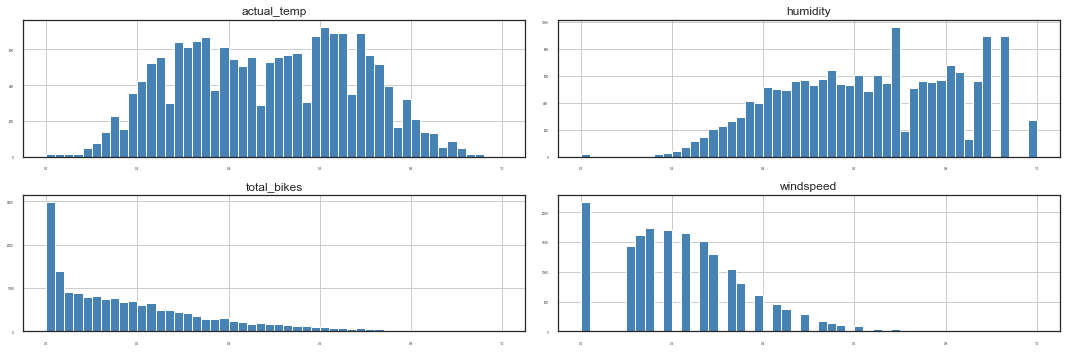

In [61]:
hours_df_num = hours_df.select_dtypes(include=['float64', 'int64'])
hours_prep_scaled.compute().hist(figsize=(15, 5), bins=50,
                                 xlabelsize=3, ylabelsize=3, color='steelblue')
plt.tight_layout()

The scale of the dataset is corrected.

### Encoding Categorical Variables

In [62]:
hours_prep_encoded = hours_prep_scaled.copy()
df_desc(hours_prep_encoded.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False
humidity,float64,0,True,False,False,False
windspeed,float64,0,True,False,False,False


In [63]:
def date_features(df):
    columns = df.columns
    return df.select_dtypes(include=[np.datetime64]).columns


def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns


def categorical_features(df):
    numerical_columns = numerical_features(df)
    date_columns = date_features(df)
    return(list(set(df.columns) - set(numerical_columns) - set(date_columns)))


def onehot_encode(df):
    #     numericals = numerical_features(df)
    #     new_df = numericals.copy()
    new_df = df.copy()
    new_df = DummyEncoder().fit_transform(new_df)  # [categorical_column])
    return new_df


def onehot_encode_single(df, col_to_encode, drop=True):
    if type(col_to_encode) != str:
        raise TypeError('col_to_encode should be a string.')
    new_df = df.copy()

    if drop == True:
        new_df = new_df.drop([col_to_encode], axis=1)

    new_df = dd.concat([new_df,
                        DummyEncoder().fit_transform(df[col_to_encode].to_frame())],
                       interleave_partitions=True)
    return new_df

In [64]:
hours_clean = onehot_encode(hours_prep_encoded)
df_desc(hours_clean.compute())

,dtype,NAs,Numerical,Boolean,Categorical,Date
actual_temp,float64,0,True,False,False,False
humidity,float64,0,True,False,False,False
windspeed,float64,0,True,False,False,False
total_bikes,float64,0,True,False,False,False
season_1,uint8,0,False,True,False,False
season_2,uint8,0,False,True,False,False
season_3,uint8,0,False,True,False,False
season_4,uint8,0,False,True,False,False
year_0,uint8,0,False,True,False,False
year_1,uint8,0,False,True,False,False


In [65]:
# Rename columns
hours_clean = hours_clean.rename(columns={'year_0': 'year_2011',
                                          'year_1': 'year_2012',
                                          'season_1': 'season_winter',
                                          'season_2': 'season_spring',
                                          'season_3': 'season_summer',
                                          'season_4': 'season_fall',
                                          'workingday_0': 'workingday_no',
                                          'workingday_1': 'workingday_yes',
                                          'month_1': 'month_jan',
                                          'month_2': 'month_feb',
                                          'month_3': 'month_mar',
                                          'month_4': 'month_apr',
                                          'month_5': 'month_may',
                                          'month_6': 'month_jun',
                                          'month_7': 'month_jul',
                                          'month_8': 'month_aug',
                                          'month_9': 'month_sep',
                                          'month_10': 'month_oct',
                                          'month_11': 'month_nov',
                                          'month_12': 'month_dec',
                                          'weather_condition_1': 'weather_condition_clear',
                                          'weather_condition_2': 'weather_condition_mist',
                                          'weather_condition_3': 'weather_condition_light_rain',
                                          'weather_condition_4': 'weather_condition_heavy_rain',
                                          'weekday_0': 'weekday_sunday',
                                          'weekday_1': 'weekday_monday',
                                          'weekday_2': 'weekday_tuesday',
                                          'weekday_3': 'weekday_wednesday',
                                          'weekday_4': 'weekday_thursday',
                                          'weekday_5': 'weekday_friday',
                                          'weekday_6': 'weekday_saturday'})

In [66]:
hours_clean = hours_clean.drop('workingday_no', axis=1)

The variable `workingday_no` has been removed, as complementary of `workingday_yes`.

In [67]:
hours_clean.head()

,actual_temp,humidity,windspeed,total_bikes,season_winter,season_spring,season_summer,season_fall,year_2011,year_2012,month_jan,month_feb,month_mar,month_apr,month_may,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday_saturday,weekday_sunday,weekday_monday,weekday_tuesday,weekday_wednesday,weekday_thursday,weekday_friday,workingday_yes,weather_condition_clear,weather_condition_mist,weather_condition_light_rain,weather_condition_heavy_rain
0,0.224490,0.81,0.0,0.015369,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0.204082,0.80,0.0,0.039959,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0.204082,0.80,0.0,0.031762,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.224490,0.75,0.0,0.012295,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,0.224490,0.75,0.0,0.000000,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


The dataset is ready for modeling.

### Training/Test Split

In [68]:
def list_features(df, target):
    features = list(df._meta)
    features.remove(target)
    return features

In [69]:
target = 'total_bikes'
features = list_features(hours_clean, target)

In [70]:
X = hours_clean[features]
X_train = X.loc[(X['year_2011'] == 1) | ((X['year_2012'] == 1) & (X['month_sep'] == 0) & (
    X['month_oct'] == 0) & (X['month_nov'] == 0) & (X['month_dec'] == 0)), features]
X_test = X.loc[(X['year_2012'] == 1) & ((X['month_sep'] == 1) | (
    X['month_oct'] == 1) | (X['month_nov'] == 1) | (X['month_dec'] == 1)), features]
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('X_train:',
                                             X_train.shape[0].compute(), 'rows |', X_train.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format(
    'X_test:', X_test.shape[0].compute(), 'rows |', X_test.shape[1], 'columns'))

X_train:   14491 rows |  57 columns
X_test:     2888 rows |  57 columns


In [71]:
y = hours_clean.copy()
y_train = y.loc[(y['year_2011'] == 1) | ((y['year_2012'] == 1) & (y['month_sep'] == 0) & (
    y['month_oct'] == 0) & (y['month_nov'] == 0) & (y['month_dec'] == 0)), :]
y_test = y.loc[(y['year_2012'] == 1) & ((y['month_sep'] == 1) | (
    y['month_oct'] == 1) | (y['month_nov'] == 1) | (y['month_dec'] == 1)), :]
y_train = y_train[target]
y_test = y_test[target]
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('y_train:',
                                             y_train.shape[0].compute(), 'rows |', 1, 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format(
    'y_test:', y_test.shape[0].compute(), 'rows |', 1, 'columns'))

y_train:   14491 rows |   1 columns
y_test:     2888 rows |   1 columns


In [72]:
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features:',
                                              X.shape[0].compute(), 'items | ', X.shape[1], 'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Train:',
                                              X_train.shape[0].compute(), 'items | ', X_train.shape[1], 'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Test:',
                                              X_test.shape[0].compute(), 'items | ',  X_test.shape[1], 'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format(
    'Target:', y.shape[0].compute(), 'items | ', 1, 'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Train:',
                                              y_train.shape[0].compute(), 'items | ', 1, 'columns'))
print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Test:',
                                              y_test.shape[0].compute(), 'items | ', 1, 'columns'))

Features:        17379 items |  57 columns
Features Train:  14491 items |  57 columns
Features Test:    2888 items |  57 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns


In [73]:
X, X_train, X_test, y, y_train, y_test = dask.persist(
    X, X_train, X_test, y, y_train, y_test)

The Train Set is arbitrarily defined as all records until August 31st 2012, and the Test Set all records from September 1st 2012. Below function will be used to repeat the operation on future dataframes including new features.

In [74]:
def train_test_split_0(df, target, features):
    X = df[features]
    y = df[target].to_frame()
    df_train = df.loc[(df['year_2011'] == 1) | ((df['year_2012'] == 1) & (df['month_sep'] == 0) & (
        df['month_oct'] == 0) & (df['month_nov'] == 0) & (df['month_dec'] == 0)), :]
    df_test = df.loc[(X['year_2012'] == 1) & ((df['month_sep'] == 1) | (
        df['month_oct'] == 1) | (df['month_nov'] == 1) | (df['month_dec'] == 1)), :]
    X_train = df_train[features]
    X_test = df_test[features]
    y_train = df_train[target].to_frame()
    y_test = df_test[target].to_frame()

    print('{:<40} {!r:>}'.format('Same indexes for X and y:',
                                 X.index.values.compute().tolist() == y.index.values.compute().tolist()))
    print('{:<40} {!r:>}'.format('Same indexes for X_train and y_train:',
                                 X_train.index.values.compute().tolist() == y_train.index.values.compute().tolist()))
    print('{:<40} {!r:>}'.format('Same indexes for X_test and y_test:',
                                 X_test.index.values.compute().tolist() == y_test.index.values.compute().tolist()))
    print()
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features:',
                                                  X.shape[0].compute(), 'items | ', X.shape[1], 'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Train:',
                                                  X_train.shape[0].compute(), 'items | ', X_train.shape[1], 'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Features Test:',
                                                  X_test.shape[0].compute(), 'items | ',  X_test.shape[1], 'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format(
        'Target:', y.shape[0].compute(), 'items | ', 1, 'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Train:',
                                                  y_train.shape[0].compute(), 'items | ', 1, 'columns'))
    print('{:<15} {:>6} {:>6} {:>2} {:>6}'.format('Target Test:',
                                                  y_test.shape[0].compute(), 'items | ', 1, 'columns'))
    print()

    return X, X_train, X_test, y, y_train, y_test

## Baseline

In [75]:
lm = LinearRegression()
lm.fit(X_train.values, y_train)
y_pred = lm.predict(X_test.values)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(
    mean_squared_error(y_test.compute(), y_pred.compute())))
print('Variance score (R2): {:.2f}'.format(
    r2_score(y_test.compute(), y_pred.compute())))

Intercept: -0.04981442133110044
Coefficients: [ 0.12162194  0.20993633 -0.07662468 -0.03277261 -0.02028516  0.00984738
 -0.00362692  0.02145953 -0.04392317  0.04396376 -0.02316936 -0.01755833
 -0.00141292 -0.00207618  0.01345699  0.00368002 -0.01022297  0.00896718
  0.02316777  0.01795153  0.00422598  0.00560081 -0.12064328 -0.13783824
 -0.14593734 -0.15676478 -0.15987671 -0.14391122 -0.08705978  0.04151926
  0.17492107  0.03581461 -0.01690215  0.0060972   0.04260202  0.03871467
  0.02368416  0.03150675  0.09118695  0.24367112  0.2166576   0.11396975
  0.03651263 -0.01140959 -0.04859113 -0.08834253  0.01835533  0.00569505
 -0.00881901 -0.0048717  -0.00493926 -0.00377265 -0.00154845  0.01974657
  0.01310665  0.00426076 -0.04805843]
Mean squared error (MSE): 0.02
Variance score (R2): 0.63


The baseline model for our dataset obtains a R square of 0.63.

## Feature Engineering

### Pipeline with Linear Regression

The Linear Regression is set into a pipeline.

In [76]:
from matplotlib import pyplot


def pipeline(df, target, algorithm):

    features = list_features(df, target)
    X, X_train, X_test, y, y_train, y_test = train_test_split_0(
        df, target, features)
    algorithm.fit(X_train.values, y_train.values)
    y_pred = algorithm.predict(X_test.values)

    print()
    print('Intercept:', algorithm.intercept_)
    print('Coefficients:', algorithm.coef_)
    print('Mean squared error (MSE): {:.2f}'.format(
        mean_squared_error(y_test.compute(), y_pred.compute())))
    print('Variance score (R2): {:.2f}'.format(
        r2_score(y_test.compute(), y_pred.compute())))

In [77]:
pipeline(hours_clean, 'total_bikes', lm)

Same indexes for X and y:                True
Same indexes for X_train and y_train:    True
Same indexes for X_test and y_test:      True

Features:        17379 items |  57 columns
Features Train:  14491 items |  57 columns
Features Test:    2888 items |  57 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns


Intercept: -0.04981442133110044
Coefficients: [ 0.12162194  0.20993633 -0.07662468 -0.03277261 -0.02028516  0.00984738
 -0.00362692  0.02145953 -0.04392317  0.04396376 -0.02316936 -0.01755833
 -0.00141292 -0.00207618  0.01345699  0.00368002 -0.01022297  0.00896718
  0.02316777  0.01795153  0.00422598  0.00560081 -0.12064328 -0.13783824
 -0.14593734 -0.15676478 -0.15987671 -0.14391122 -0.08705978  0.04151926
  0.17492107  0.03581461 -0.01690215  0.0060972   0.04260202  0.03871467
  0.02368416  0.03150675  0.09118695  0.24367112  0.2166576   0.11396975
  0.03651263 -0.01140959 -0.04859113 -0.0883

#### Dask-XGBoost

Another pipeline is created using Dask-XGBoost.

In [78]:
def pipeline_xgb(df, target, client):

    features = list_features(df, target)
    X, X_train, X_test, y, y_train, y_test = train_test_split_0(
        df, target, features)

    params = {'objective': 'binary:logistic',
              'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
              'min_child_weight': 0.5}

    bst = dask_xgboost.train(client, params, X_train,
                             y_train, num_boost_round=10)

    ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()

    y_pred = dask_xgboost.predict(client, bst, X_test).persist()

    print()
    print('Mean squared error (MSE): {:.2f}'.format(
        mean_squared_error(y_test.compute(), y_pred.compute())))
    print('Variance score (R2): {:.2f}'.format(
        r2_score(y_test.compute(), y_pred.compute())))

Same indexes for X and y:                True
Same indexes for X_train and y_train:    True
Same indexes for X_test and y_test:      True

Features:        17379 items |  57 columns
Features Train:  14491 items |  57 columns
Features Test:    2888 items |  57 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns



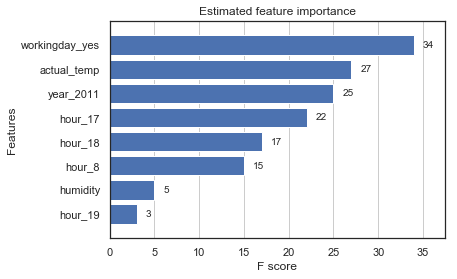


Mean squared error (MSE): 0.10
Variance score (R2): -0.94


In [79]:
pipeline_xgb(hours_clean, 'total_bikes', client)

#### Dask_ml.XGBoost

Another pipeline is created using Dask_ml.XGBoost.

In [80]:
def pipeline_daskml_xgb(df, target, algorithm):

    features = list_features(df, target)
    X, X_train, X_test, y, y_train, y_test = train_test_split_0(
        df, target, features)
    algorithm.fit(X_train.values, y_train.values)
    y_pred = algorithm.predict(X_test.values)

    print()
    print('Mean squared error (MSE): {:.2f}'.format(
        mean_squared_error(y_test.compute(), y_pred.compute())))
    print('Variance score (R2): {:.2f}'.format(
        r2_score(y_test.compute(), y_pred.compute())))

In [81]:
xgbreg = XGBRegressor()
pipeline_daskml_xgb(hours_clean, 'total_bikes', xgbreg)

Same indexes for X and y:                True
Same indexes for X_train and y_train:    True
Same indexes for X_test and y_test:      True

Features:        17379 items |  57 columns
Features Train:  14491 items |  57 columns
Features Test:    2888 items |  57 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns


Mean squared error (MSE): 0.02
Variance score (R2): 0.68


#### Random Forest

Another pipeline is created using Random Forest.

In [82]:
def pipeline_rf(df, target, algorithm):

    features = list_features(df, target)
    X, X_train, X_test, y, y_train, y_test = train_test_split_0(
        df, target, features)
    with parallel_backend('dask'):
        algorithm.fit(X_train.values, y_train.values)
        y_pred = algorithm.predict(X_test.values)

    print()
    print('Mean squared error (MSE): {:.2f}'.format(
        mean_squared_error(y_test, y_pred)))
    print('Variance score (R2): {:.2f}'.format(
        algorithm.score(X_test, y_test)))

In [83]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
pipeline_rf(hours_clean, 'total_bikes', regr)

Same indexes for X and y:                True
Same indexes for X_train and y_train:    True
Same indexes for X_test and y_test:      True

Features:        17379 items |  57 columns
Features Train:  14491 items |  57 columns
Features Test:    2888 items |  57 columns
Target:          17379 items |   1 columns
Target Train:    14491 items |   1 columns
Target Test:      2888 items |   1 columns



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys



Mean squared error (MSE): 0.05
Variance score (R2): -0.00


***

*Ashley O'Mahony | [ashleyomahony.com](http://ashleyomahony.com) | May 2019*  

***